
https://xgboost.readthedocs.io/en/latest/python/python_intro.html#training

target clipped
booster: gbtree
max_depth=8,  트리의 최대 깊이
n_estimators=500, 트리의 갯수
min_child_weight=1000, child에서 필요한 모든 관측치에 대한 가중치의 최소 합
colsample_bytree=0.7, 각 트리마다 feature 샘플링 비율
subsample=0.7, 각 트리마다 데이터 샘플링 비율
eta=0.3, 학습 단계별로 가중치를 얼만큼 사용할지 결정
seed=0)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

import time

In [3]:
data = pd.read_pickle('./data/data_1.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8032887 entries, 827691 to 8860577
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   month_id                    int8   
 1   shop_id                     int8   
 2   item_id                     int16  
 3   cnt_month                   float32
 4   city_id                     int8   
 5   cat_id                      int8   
 6   main_cat                    int8   
 7   sub_cat                     int8   
 8   year                        int16  
 9   month                       int8   
 10  sales_month                 int8   
 11  cnt_month_1                 float32
 12  cnt_month_2                 float32
 13  cnt_month_3                 float32
 14  item_id_mean_cnt_1          float32
 15  item_id_mean_cnt_2          float32
 16  item_id_mean_cnt_3          float32
 17  sub_cat_mean_cnt_1          float32
 18  sub_cat_mean_cnt_2          float32
 19  sub_cat_mean_cnt

In [4]:
DATA = data.copy()

In [5]:
data.columns

Index(['month_id', 'shop_id', 'item_id', 'cnt_month', 'city_id', 'cat_id',
       'main_cat', 'sub_cat', 'year', 'month', 'sales_month', 'cnt_month_1',
       'cnt_month_2', 'cnt_month_3', 'item_id_mean_cnt_1',
       'item_id_mean_cnt_2', 'item_id_mean_cnt_3', 'sub_cat_mean_cnt_1',
       'sub_cat_mean_cnt_2', 'sub_cat_mean_cnt_3', 'price_mean_mean_cnt_1',
       'price_mean_mean_cnt_2', 'price_mean_mean_cnt_3',
       'item_id/city_id_mean_cnt_1', 'item_id/city_id_mean_cnt_2',
       'item_id/city_id_mean_cnt_3', 'shop_id/cat_id_mean_cnt_1',
       'shop_id/cat_id_mean_cnt_2', 'shop_id/cat_id_mean_cnt_3'],
      dtype='object')

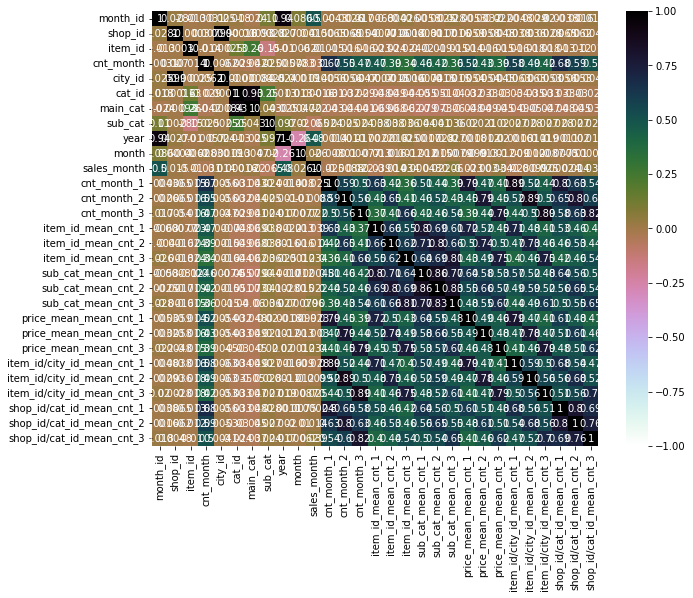

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap="cubehelix_r")
plt.show()

feature only _1

In [7]:
#사용 feature 설정

features = ['month_id', 'shop_id', 'item_id', 'city_id', 'cat_id','main_cat', 'sub_cat', 'year', 'month', 'sales_month', 'cnt_month_1', 'item_id_mean_cnt_1', 'sub_cat_mean_cnt_1','price_mean_mean_cnt_1','item_id/city_id_mean_cnt_1', 'item_id/city_id_mean_cnt_2','shop_id/cat_id_mean_cnt_1', 'cnt_month']

data= data[features]


clip only target

In [8]:
# train/validation/test data split, target clip
X_train = data[data['month_id'] < 33].drop(['cnt_month'], axis=1)
y_train = data[data['month_id'] < 33]['cnt_month'].clip(0,20)

X_valid = data[data['month_id'] == 33].drop(['cnt_month'], axis=1)
y_valid = data[data['month_id'] == 33]['cnt_month'].clip(0,20)

X_test = data[data['month_id'] == 34].drop(['cnt_month'], axis=1)

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape

((7596885, 17), (7596885,), (221802, 17), (221802,), (214200, 17))

modeling

In [10]:
xgb_model = XGBRegressor(max_depth=8,  #트리의 최대 깊이
                         n_estimators=500, #트리의 갯수
                         min_child_weight=1000, #child에서 필요한 모든 관측치에 대한 가중치의 최소 합
                         colsample_bytree=0.7, #각 트리마다 feature 샘플링 비율
                         subsample=0.7, #각 트리마다 데이터 샘플링 비율
                         eta=0.3, #학습 단계별로 가중치를 얼만큼 사용할지 결정
                         seed=0)

In [11]:
start = time.time()
xgb_model.fit(X_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              verbose=20)

In [ ]:
#time
end = time.time()
print(f'소요시간(s) : {end-start}')

소요시간(s) : 3945.51842546463


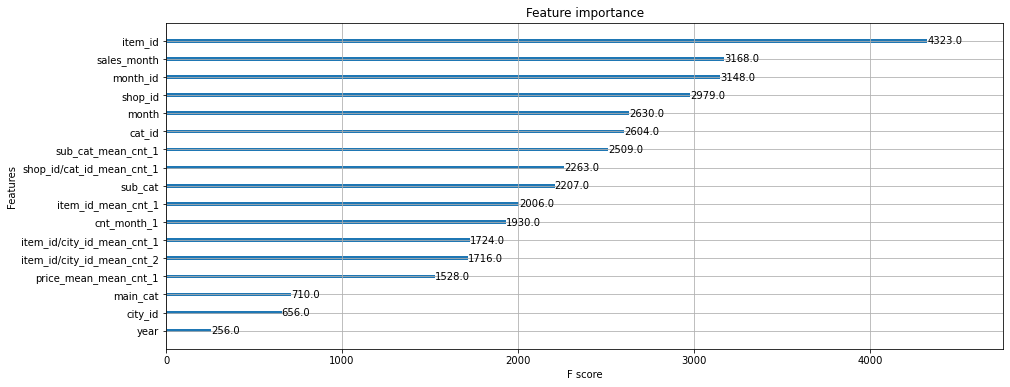

In [ ]:
#feature imporatance
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
#prediction, validation
train_pred = xgb_model.predict(X_train).clip(0, 20)
val_pred = xgb_model.predict(X_valid).clip(0, 20)
test_pred = xgb_model.predict(X_test).clip(0, 20)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, val_pred)))

Train rmse: 0.7975695
Validation rmse: 0.8318943


In [ ]:
# 제출 파일 생성
df_test = pd.read_csv('./data/test.csv')
submission = pd.DataFrame({"ID": df_test.index, "item_cnt_month": test_pred})
submission.to_csv('sek_xgb1_1_submit.csv', index=False)